# Part 1: Basic Synthetic Data Generation

This notebook demonstrates the basic synthetic data generation capabilities of DeepBridge. We'll learn how to create synthetic data that preserves statistical properties of the original data.

## Contents
1. Setting up the environment
2. Loading the sample dataset
3. Creating synthetic data with DBDataset
4. Comparing distributions between original and synthetic data
5. Evaluating synthetic data quality
6. Direct usage of SyntheticDataGenerator
7. Correlation preservation in synthetic data

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import HTML


import sys
import os

sys.path.append(os.path.expanduser("~/projetos/DeepBridge"))


from deepbridge.core.db_data import DBDataset
from deepbridge.synthetic import synthesize


# Create a sample dataset
np.random.seed(42)
n_samples = 1000
df = pd.DataFrame({
    'feature1': np.random.normal(0, 1, n_samples),
    'feature2': np.random.normal(5, 2, n_samples),
    'feature3': np.random.choice(['A', 'B', 'C'], n_samples),
    'feature4': np.random.uniform(0, 10, n_samples)
})
df['target_binary'] = (df['feature1'] + df['feature2'] > 5).astype(int)

# Explicitly ensure feature3 is object type (not category)
df['feature3'] = df['feature3'].astype(str)

# Make a copy for model training with dummy variables
X_model = df.drop('target_binary', axis=1).copy()
X_model = pd.get_dummies(X_model, drop_first=True)  # Handle categorical variable
y = df['target_binary']

X_train, X_test, y_train, y_test = train_test_split(X_model, y, test_size=0.2, random_state=42)

# Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create the DBDataset
from deepbridge.core.db_data import DBDataset

# Verify dtype before creating the dataset
print("dtype of feature3:", df['feature3'].dtype)
if df['feature3'].dtype.name == 'category':
    df['feature3'] = df['feature3'].astype('object')
    print("Converted feature3 to object type")

# Now create the dataset
dataset = DBDataset(
    data=df,
    target_column='target_binary',
    model=rf_model,
    categorical_features=['feature3']
)

# Double check the dataset's categorical features
print("Dataset categorical features:", dataset.categorical_features)
print("Feature3 dtype in dataset:", dataset._original_data['feature3'].dtype)



/home/guhaase/projetos/deepbridge_homol/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dtype of feature3: object
Feature names unseen at fit time:
- feature3
Feature names seen at fit time, yet now missing:
- feature3_B
- feature3_C

Dataset categorical features: []
Feature3 dtype in dataset: object



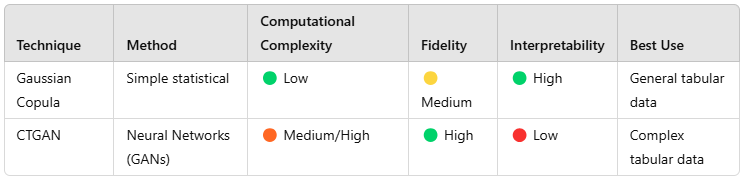

In [8]:

HTML(f'<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAuUAAACxCAYAAABjusM2AAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAEr5SURBVHhe7d1/XFRV/j/wF4KBjgwSKkNKEQpNiOvQKlsqJBaxYNrsqrloXzMVWTL7LOKvdTVibU1NmozKNTLNTHLFXawV1lDZBWpdPxFj/poFM7bRZkwNGRilRPn+scz9zL3MDMMvhx+v5+PB46HnnHvncu+Zc973nHMvbo2NjY0gIiIiIiKX6SNNICIiIiKi24tBORERERGRizEoJyIiIiJyMTdHa8ovXLiAS5cuwWw2w0ExIiIiIiJqgZubG2QyGQYPHoyhQ4eK82wF5fX19dDpdAAAuVwOT09PuLm5SYtRF3Hu3DkEBwdLk6mXY70gV2Md7Hw8xz0br2/P09DQgBs3buDq1atwd3eHUqmEl5cXYG/5ik6ng6enJ4YMGQIvLy8G5ERERERE7eTh4YF+/fph8ODB6Nu3rzAIDltB+YULFwAAPj4+0iwiIiIiImonDw8PeHt74+bNm0Ls3Swov3TpEuRyuTSZiIiIiIg6iIeHBwYOHIhLly4BtoJys9kMT09PaTIREREREXWgvn37wmw2A7aC8sbGRq4hJyIiIiLqZB4eHsIbDpsF5UREREREdHsxKCciIiIicjEG5URERERELsagnIiIiIjIxRiUExERERG5GINyImrm5s2bKCgowJQpU6BUKqFUKjF+/Hh8/vnn0qI9yrfffos5c+bg448/lmZ1ihUrViAmJkZ4Ry0REfVeDMqJSKShoQFr165FamoqAOCFF17AK6+8ggkTJuDHH3+UFu8yLly4gDlz5uC9996TZtlUW1uLJUuW4MUXXxTSrl69Cp1Oh8uXL4vKEhERdTYG5UQkkp+fjz179iA1NRV5eXmYNWsWpkyZgg0bNmDcuHHS4l3G1atX8eWXXzp941BfX4/y8nJcv35dSAsLC8OxY8fwzDPPiMoSERF1NgblRCS4du0acnNzMWrUKMyePRvu7u7SIgCAS5cuYc2aNQgPD4dSqUR0dDTy8/OFP4BgWZaxd+9ejBs3DkqlEps2bYJer8dTTz0FpVKJhIQEnDlzBgBw6tQpqFQqvPHGG9i0aRPCwsKgUqmwfft2NDQ0CPnZ2dnCMWRnZ0OlUuHUqVMoKirCtGnTUF9fj8zMTCH9yy+/xMyZM4UlOE899RSMRiNOnTqF2NhYGAwG7N+/H0qlEkVFRc0+p6GhAbt27UJ0dDSUSiXCw8Px8ssvC4G8pfzmzZuxevVqKJVKjBs3DsXFxUBT4P/aa69h7NixUCqVUKlUyMnJEc4TERGRBYNyIhKYzWbo9Xrce++9GDBggDQbAFBXV4fly5ejtLQUGzZswL59+6BUKrF06VIUFRUJ5QwGA44ePYrs7GzEx8dj27ZtmDdvHmbNmoX169dDr9cjOzsbDQ0Nwja7d++Gr68v9u7di4cffhgbN27EkSNHhHx7xo0bh3feeQdeXl5ISUnBoUOHcN999+HMmTOYMWMG/v73vyMjIwNffPEFNm/ejNDQUHz44YcYMmQI4uLiUFJS0mwWoLGxETt27MD69esxbdo0fPTRR/j1r3+N999/Hxs2bBAd965duzB27Fjs3LkTMpkMGzduRHV1Nerq6lBbW4v3338fBw4cQHh4ODZs2IDTp0+LPouIiIhBORG1yhdffIGjR49i6dKlmDx5MkaOHIl169YhKCgI+/fvF4JVb29vJCcnY+TIkXjqqafg7u6OyZMnIyEhAXFxcRgzZgwuX74sWm4SHx+PefPmYeTIkVi6dCkGDRokjDo74unpCV9fXwBA//79MWjQIHh4eGDmzJmYPn06FAoFpkyZgjFjxuDChQu4ceMG/Pz84O7uDi8vLwwePBienp6ifV65cgV79uzBY489hkWLFiE0NBSLFi1CYmIiDh8+DIPBIJSdOnUqpk6disjISEybNg3nz5/Ht99+i0GDBmHNmjVQKpUYPnw45s+fj/r6enz33XeizyIiImJQTkQCT09P+Pn54cqVK6ivr5dmAwDOnTsHT09PBAUFCWmWQLi6uloIsgcMGCAEyl5eXvDw8IBMJgMA9OvXD0OGDBG2t1AoFHBzcwOstrlx44a0mNPOnj2LlStXIjY2FpGRkTh27Ji0iF2XL1/G999/j/vvvx8eHh4AADc3NygUCtTW1sJkMgllrY/beslPfX099uzZgyeffBLjxo1DSkqKkEdERGSNQTkRCeRyOR5++GF8+umnOHTokM21z8HBwfjhhx9QVVUlpF27dg2XL1/G0KFD0a9fP1H51jCbzcK/Lcs/vL294e7uDnd3d1H+zZs3hX/bcv78ecyfPx/Xrl3DO++8g8LCQkRGRkqL2TVo0CDceeedOHPmjDD639jYCKPRiDvvvBODBg2SbtJMdnY2Xn75ZTz99NP46KOPsHnzZmkRIiIigEE5EUn96le/Qnh4OJYuXYqnn34aubm5+Pjjj5GamorS0lKMHDkSI0aMwKZNm3DgwAHodDqsXbsWVVVVePzxx4UR47b44IMPsH//fuh0OmzatAn19fV4/PHH4e/vj4CAAOzfvx8lJSXIz8/Htm3bRNtaAvcTJ07gn//8J7766ivU1dWhT58+6NOnDw4dOiR6z7qbmxs8PDzw1VdfoaSkBBUVFaL9+fn5ISYmBn/729/w5ptvoqKiAu+++y5ycnLw6KOP2hzpl7p48SLQNDNw+fJlbN++XVqEiIgIYFBORFKDBw/G9u3bsWDBApw5cwarV6/GsmXLcPbsWfj6+sLPz09488myZcugVqtx7tw5vPvuu80elmytJ554Ah999BHUajVOnjyJrKwsjB49Gr6+vli+fDl++OEHJCUlYd++fXjiiSdE244YMQKJiYn45JNPkJaWhsGDB2P27Nn45JNPEBcXB6PRiPDwcKG8n58fnnnmGeh0OiQnJzf7Az5ubm5YsmQJ0tLSsGvXLkydOhV//OMfkZaWhiVLljh18zF79mzcddddePbZZ7F8+XJMnDhRWoSIiAgA4NYomZ8uLS1FcHCwdRJ1cefOneM1o2a6U704deoUZs+ejUWLFiEpKUmaTd1Ud6qD3RXPcc/G69s7nDt3DhMmTOBIORERERGRqzEoJyIiIiJyMQblRORyI0eOhFar5dIVIiLqtRiUExERERG5GINyIiIiIiIXY1BORERERORiDMqJiIiIiFyMQTkRERERkYsxKCciIiIicjEG5URERERELsagnIiIiIjIxRiUExERERG5GINyIiIiIiIXa3dQXlRUBKVSafMnJiYGly5dkm7SokuXLiEmJgYrVqyQZjmlsbER7733HhYuXIirV69Ks6mJ5drdf//9KCkpkWbj1KlTUKlUUCqVKCoqkmY7pb3X0p4VK1a0uX5Ry27evImCggJMmTJF+D6PHz8en3/+ubTobdFR9YhtQ9d37do1zJkzp1l/kp2djbq6Ojz//PP44x//iMbGRummQCvbhuzsbKhUKpw6dapX1Q3LOZ4zZw6uXbsmze7RnGlLDh06hNmzZ6OqqgqQ1Klvv/0Wc+bMwccffyzdrMuw/I7W358pU6bg2LFj0qIdzhJXSGMGe+kk1u6gPCwsDJs3b8bmzZvx+OOPw8PDA2lpadi8eTMyMjLg7e0t3aTT3bx5E19//TXOnz+P+vp6aTZJNDY2Ij8/v1knd+TIkVafv/feew8zZ850qkOkrqmhoQFr165FamoqAOCFF17AK6+8ggkTJuDHH3+UFu9WbLUNrLNd07333ouNGzcK/cukSZNQV1eHs2fPwmg04ubNm9JN2oV1w7ELFy5gzpw5eO+996RZLtfR10mv16OystLmDcvVq1eh0+lw+fJlAEBtbS2WLFmCF198UVrU5caMGSPEYnV1dVi2bBnOnz8vLea0rvy79hTtDsr9/f0RFxeHuLg43HffffDw8MC4ceMQFxeH6OhoeHl5STfpdB4eHnjxxReRn58PhUIhzSaJ++67D5999hkuXLggpF2+fBkFBQWIjIwUlW3J6dOn8d1330mTqRvJz8/Hnj17kJqairy8PMyaNQtTpkzBhg0bMG7cOGnxbsVW28A62zUNHjwYjz76qNC/DB8+HAqFAvn5+XjxxRfh4eEh3aRdWDccu3r1Kr788ssueWPe0dfpmWeewbFjxxAWFibNQlhYGI4dO4ZnnnkGAFBfX4/y8nJcv35dWtTlhg4diri4OMycOROzZs1CXV0d6urqpMWc1pV/156i3UF5S6qqqvDUU09BqVQiPDwcr732GhoaGoCmkYm//vWviI6OhlKphEqlEk2P37hxA3/84x8RFhaGsLAwvPfee2hsbBSmZpYsWSLkq1Qq5OTkCKO90inMY8eOISEhAUqlEgkJCcjKyhKmUmxN5VmWbmRnZwNWo8mWY42OjkZxcbFwrN3Zz3/+c1y7dg2ffvqpkPbll1/i+vXreOSRR0Rl7Z0Hyzncv38/DAYDoqKiRNOD9q4lmqba1qxZg/DwcGGf1iP3DQ0N2L59u7CUZunSpT1+etlVrl27htzcXIwaNQqzZ8+Gu7u7tAjgxDWzfP/27t2LcePGQalUYtOmTdDr9UJ7kJCQgDNnzgBW37c33ngDmzZtEr7T27dvF9oLKXttS2VlJR566CEsWbIEDQ0NqK+vx69//WvMmDEDV69eFY7tm2++aVZnly9fjiVLliAhIUEYCWtsbMTatWtFaeQa0qUHzrQNly5dQmpqqtD2LF++3G5g4qhupKWl4cknn8SCBQuEkfT6+nosWLBAlNYdtdSnFhUVYdq0aaivr0dmZqaw5Mdy/seOHSsskbB8py1Lg7KysjBmzBisWLHCqe/5ihUr8PDDD+PVV19FeHg4srOz7X6OvX6nvr4er732mlBeGh+gKf7YtWsXVCoVwsLCsG7dOiHYtF7WJGUdG5w6dQqxsbEwGAzYv38/lEoltm3bhlGjRmHXrl3CNhUVFRg7dqwo7Xa6cuUKSktLMXbsWAQFBQFW3x3pOYXVrIiyaenL8uXLodVqm/2u7VmKcuLECWF5ZFhYGF577TXAQYzRW3RqUP7tt98iOTkZAHDgwAGsWbMG77zzDnJzcwEAO3fuxLJlyzBhwgTk5eVh9erVou0LCgpQV1eHDz/8ED/5yU/w1ltv4dy5c0L+J598gj59+mDv3r1QKpV47bXXRPkWlZWV+J//+R94enpi165d+M1vfoM///nP0mIOffLJJ1i+fDmmTZuGwsJCREZGYsWKFaisrJQW7XaGDx+OqKgoFBYWor6+Hg0NDfjrX/+KSZMmITAwUFTW3nk4f/48Xn/9dcTFxWHIkCHNrqe9a1lXV4fly5ejtLQUGzZswL59+4TO1fKFz83NxcaNGzF16lR89NFHCAoKsrkGntrPbDZDr9fj3nvvxYABA6TZAODUNQMAg8GAo0ePIjs7G/Hx8di2bRvmzZuHWbNmYf369dDr9UKHa7F79274+vpi7969ePjhh7Fx40YcOXJEyLdw1LaEhIRg4cKFOHLkCLRaLYqLi/G///u/WLFiBQYOHCjsw8vLq1mdXbNmDR555BFUVVUJHdR3332HoqIixMfHY9CgQcL21LmOHTuGBx54QAgMbAUALbUNlrp68uRJfPjhh3jrrbdQVFSE119/vdlyPWu26saLL76IqKgoHD9+HN988w0A4KuvvkJ5eTl+8YtfuGRWuKPZ61PHjRuHd955B15eXkhJScGhQ4cQGhqKHTt2IDMzE0uXLsWBAwfg4+OD5cuX48qVK0DTTcvnn3+Ow4cPY8OGDcLntPQ9v3jxIr7//nt8/vnnWLBggd3PuXbtWrPrtHr1atTV1aG2thbvv/8+Dhw4gPDwcGzYsAGnT58WPuPw4cP4+uuv8ac//Qlz587Fzp07Wx0033ffffjwww8xZMgQxMXFoaSkBGq1Gvfffz/+/ve/Czdq//jHP9C/f39MnDhRuotOZQmex48fD09PT/zud7+Dl5cXGhsb7Z7Tb7/9FhkZGdDr9dizZw/27dsHuVyO4ODgZr9rW2dOq6ur8dvf/hb9+vXDgQMHsHXrViHPXozRE2ItZ3RqUP7JJ5/g+++/xwsvvIDhw4dDrVZj3LhxOHjwIAwGA/bt24dHHnkEv//976FUKjF9+nSMGTNG2H7s2LF49tln8ZOf/ASzZ89GTU2N0BgCwIMPPog5c+Zg5MiRmDdvXrN8i08//RR1dXVIT0/HmDFj8Nhjj2HJkiXSYnZdv34dH374IR588EEkJycjMDAQKSkpuHXrlmh0ubvq27cvfvGLX6C8vBw6nQ7nzp3Dv/71L0ycOBFubm5COUfn4bPPPsPAgQPh5eUFd3d3+Pn5iZ4nsHctv/jiCxw9ehRLly7F5MmTMXLkSKxbtw5BQUHYv38/amtrcfDgQYwaNQrLly9HaGgofv3rXyM2NlbYN91eLV0zS5Dt7e2N5ORkjBw5Ek899RTc3d0xefJkJCQkIC4uDmPGjMHly5dF0+Hx8fGYN28eRo4ciaVLl2LQoEE2R0kctS3Xr1/HzJkz8cADD+CVV17B66+/jmnTpuGnP/2paB9ubm426+zPfvYzBAUF4e9//zsaGxtx6tQpmM1mxMXFibanziVdUy5dSnD9+vUW24YvvvgC//rXv/DCCy/gJz/5CSZOnIgnnngCRUVFQuBoi726YakDlgfmPvvsM/j7++NnP/uZZA/dk70+1dPTE76+vgCA/v37Y9CgQaipqcGePXswc+ZMPPnkkxg+fDieffZZfPXVV8IIs5ubG5KTk+Hj4yP6nJa+5z4+PnjmmWfg5eWFK1eu2P2c06dP27xOgwYNwpo1a6BUKjF8+HDMnz8f9fX1oiUuP/3pT7Fs2TKh3oSHh+Ozzz5r1dIMDw8P+Pn5wd3dHV5eXhg8eDD8/PwwdepU4ebt2rVrKCkpwaOPPoqhQ4dKd9GpLGvKX3nlFVRXV+OXv/wlTp8+7fCcWgYjAKBPnz5QKpX47W9/C29v72a/q6enp+jz2qJv376YMGECnnvuOYcxRk+ItZzRqUH5mTNnUFtbi6lTp0KpVGL06NEoLi7GzZs3cfHiRRgMBowePdru2sCAgAD0798fAGyO2vn5+QmjE3379pVmC86ePYtBgwaJvhC29mdPXV0dqqqqUFpaKkyTTp48GTU1Nbhx44a0eLd0//33w9/fHyUlJfjHP/6BoUOHIiIiQlSmPefB3rU8d+4cPD09hSk1WDX61dXVuHr1Ks6fPy8aufXw8OgRo1JdkaenJ/z8/HDlyhW70/EtXTNLkD1gwAChI/fy8oKHhwdkMhkAoF+/fhgyZIiwvYVCoRBuBC3b2KpbjtqWxsZG9O/fH0lJSTh58iRMJhPmzp0rusF0ZNCgQYiPj8c///lPXL58GYWFhRg1ahTuvvtuaVHqRNI15f7+/qJ8s9ncYtvw73//G7du3UJSUpIw4r5r1y40NDQ4HCm3Jzg4GFFRUfj73/+OK1euoKSkBA899BD8/PykRbslZ/tUNI1mX7p0CR988AHuv/9+KJVKzJs3D7du3RIewvX09GwWkMOJ73n//v0hl8sBJz9Hqr6+Hnv27MGTTz6JcePGISUlRVpE9Lt6eHigf//+QvvRXhMnTkT//v1x7NgxfP3119DpdM0GuW4Hy5ryKVOm4A9/+APQNEjp6Jz26dMHq1atwpAhQzBjxgxERUV1yMy05fq6u7vD19cXL7zwAurq6vDYY49h8uTJOHPmTLtijJ6iU4Py+++/Hz4+Pvjwww9RUlIi/Lz++usYOnQo7rzzTpw5c8bumtGOMmzYMFRXV4vukq0fanRzc4O7uzuuXbsmHMutW7eE/AEDBiAoKAjR0dEoKioS/S6zZ88WynVnlkBk9+7d2LVrF2JjY5vduHTGeQgODsYPP/wgvHoKTeuaL1++jKFDh8LX1xdDhgyBwWAQ1vvX19c7HOWitpPL5Xj44Yfx6aef4tChQzY7qJauWb9+/UTlW8NsNgv/rq6uRl1dnc03ODlqW/r164dr164hOzsbISEhaGhowMcff2zzd7EnLi4ONTU1OHLkCI4ePdpjlif0JJYbO0dtg+XlA2+88YaonuTm5uLOO++02ptzPDw88Itf/AL//ve/cfjwYZw9exZTpky57cFWV+Dv74/Bgwdj9uzZonNb4sSyBme/52jj52RnZ+Pll1/G008/jY8++gibN2+WFhGWasKq/bKMuLfX0KFD8eijj6K4uBj5+fkICgpqNsjlSi2d06CgIOzZsweHDh1CcHAw0tPTRTGTI3K5HB4eHigtLRXa3MbGRvzrX/+Cj4+PMDgaGRmJAwcO4C9/+Qtu3LiBtWvXws3NrcNjjO6mU4PyyMhI3Lp1C2+99RauXLmCGzdu4C9/+QsqKiowaNAgxMTEID8/HxkZGdDpdMjNze2U9yA/+OCDuHnzJtauXYuysjLs379f9Fqnfv36Yfjw4Th9+jRycnJw6tQp/OEPfxBGCvv164fo6Gh89tln2LdvH27cuIErV67gvffes/nKpO4qLi4ODQ0NuHbtGh5++GFptlPnoW/fvqiursbRo0dtLjuQGjlyJEaMGIFNmzbhwIED0Ol0WLt2LaqqqvD4449jwIABePDBB3Hs2DFs3rwZp06dwhtvvHFb3rfaW/3qV79CeHg4li5diqeffhq5ubn4+OOPkZqaitLS0havWXsClA8++AD79++HTqfDpk2bUF9fj8cff1xazGHbgqY1q8ePH8cf/vAHPPPMM9iyZQtOnDgh3Q1gp87ec889GDlyJDIzMyGTyXrM8oSeRCaTtdg2hIaG4u6778abb76J//znP7h58yZKS0tRUlLiVPBlq26Eh4fDx8cHmZmZCAsLg1KplG7WI7m7u8Pd3R0nTpzAP//5T9TV1WH8+PHYt28fioqKcPPmTfznP//Bhx9+aHcE28LZ7zkADBw4sMXPkV6nixcvAk191uXLl7F9+3bJXv+7pnzr1q2oqKjAyy+/jK+//hpPPPFEq5dkuLm5wcPDA1999RVKSkpQUVEBNzc3PPLIIzh69Cg++OADTJ06tdkg1+1QX18Po9GIoqIi/O53vwMAjB8/3uE5raurw2uvvQadToc+ffqInqOx9btK3X///YiMjMQHH3yAlStX4uOPP8bKlSvxwQcfID4+Hvfccw8uX76MzMxMfPPNN7jjjjtEM6otxRg9XacG5WFhYXjzzTdhMBigVqsxadIkHD58GH5+fnBzc8OSJUvw3HPP4W9/+xvUajVef/113HHHHdLdtNvo0aOxYcMGfPPNN5g9ezYOHDiABQsWiMosWLAADzzwADQaDVJSUhATEyMaGft//+//IS0tDe+99x4mTZqE6dOn49q1a8KSjJ7gnnvuQUREBKKiohAcHCzNBpw4D7Nnz8bgwYOxbNky/OMf/5Bu3oyfn5/wpPuyZcugVqtx7tw5vPvuu8IoyIIFCzBnzhy8//77mD17Nvz8/PDoo49Kd0UdZPDgwdi+fTsWLFiAM2fOYPXq1Vi2bBnOnj0LX19fp65ZWz3xxBP46KOPoFarcfLkSWRlZWH06NHSYg7blpMnT2Lr1q2YM2cOwsLC8Mtf/hKBgYHYuHGjzbdu2Kqznp6eeOKJJ2AymfCzn/2sxyxP6GlaahsUCgXeeustyGQyPPXUU5g4cSLefvttp1+Va6tu+Pr6CjMpEydO7DUzKCNGjEBiYiI++eQTpKWl4ccff8SKFSswc+ZM/P73v8fEiRORkpKCvn37ttiPO/s9R9PsREufI71Os2fPxl133YVnn30Wy5cvt/mA5WOPPYbvv/8eU6dOxeHDh7F8+fI2PTfi5+eHZ555BjqdDsnJycIb337yk59AqVSib9++rX61cEc5ePCgcL7q6+vx5ptvIiwszOE59fLywtWrV/HLX/4SkyZNwldffYVXXnkFw4YNs/u7Wuvfvz82bNiAGTNm4MCBA1i2bBmOHDmCpKQkrFixAh4eHvD09IROp0NcXBwmT56MO+64Axs3bsSAAQNajDF6OrdGyZxuaWmp3YCsJykqKkJKSgq2bNmCmJgYaXa3cu7cuV5xzah1ulO9OHXqFGbPno1FixYhKSlJmu0SH330EV544QXs2LEDKpVKmk1O6E510FmNjY14/fXX8ec//xkffPABhg0bJi1yW3Wnc9wVv+ed5erVq0hKShIGBOw9O9eS7nR9qe3OnTuHCRMmdO5IORFRd3Pt2jV88skn0Gg0ePDBB3vN8gRq2dWrV7F3715s374dcXFxt/1tGtT13bx5E3q9Hq+++irOnDmDadOmtTkgp96HQTkRkZWMjAw8//zzGD16NNauXdtrlieQY9euXcPzzz+PF198EU8++SRSU1Pb9fwE9Uw6nQ5TpkzBoUOHsHHjxnYv6aPepdcuX+lJOL1FtrBekKuxDnY+nuOejde3d+DyFSIiIiKiLoJBORERERGRizEoJyIiIiJyMQblREREREQuxqCciIiIiMjFGJQTEREREbkYg3IiIiIiIhez+Z5yIiIiIiK6PSZMmNA8KK+oqEBoaKh1EnVxvGZkC+sFuRrrYOfjOe7ZeH17B8t15vIVIiIiIiIXY1BORERERORiDMqJiIiIiFyMQTkRERERkYsxKCciIiIicjEG5URERERELsagnIiIiIjIxRiUExERERG5GINyImpR3a0fsKemDKmGXEyuegtPfvMOXrj4VxSZK3ATt6TFiTpewxU0fv8X3Pp2E279ZxluXViHxis5wA/npCWpjQwNNXjzyj+w8MJu/PzrN/C0fic2XirEifpvpUWJqBPwL3r2ALxmZEtH1Yud1f/C4m//BNOtemkWACDkjsHYd89CjPK6S5pFvVyH1MHGBtz6LhuNV/ZIcwRuAyLRZ+jvAHcfaVaP1xHn+EbjTawy7kfm5cMQBQRWfj4gDLvungs/d5k0izpRR1xf6vo65S96arVa+Pv7Qy6XCz8JCQkwm83Sop3KaDQiLCwMBQUF0iySKCgoEF2v5ORk4Dacw4KCApfUDUe0Wi3CwsKg1WqlWQ61dTtrRqMR48ePb9c+OsO26s/w9PmddgNyAKj88RIeOvsKzv14WZrVTFe87tS13fp2g8OAHAAa647hZtVvgMYb0ixywrzz72OTg4AcAP5Wdxox517Dj40N0qxmkpOTodFopMnQaDRt7mPYdrSe2WxGQkKCqI/39/fvcv1MR/Z/lt/Z2Xol1d7t26vDgnKNRoO4uDgcPHgQJpMJJpMJBoMBgYGBqK2tlRbvVAqFAqdPn0Z8fLw0i6xoNBpkZWXBYDAI1ywyMhJms7lbnkPrBt8Z0vIqlQqnT5+GSqUSlZNq63bdzYUbV/H8hT9Jk20yN/6IX33zrjSZqF0aaz9FY02hNNm2H77GrUvbpanUgo9MX2LX1f+VJtt0ov5bpF88IE1uk+7Yx3QnWq0WwcHBiI2NFfp3k8mElStXwmAwSIt3adI+tyfrkKBcq9UiNzcXx48fFwUmMpkMW7duhUKhEJWnrkGn0yE2NhYy2f9NR86fP1/0f+q93v6+FNdaMfL4v9f/g6PXvpYmE7XZrRZGyKUav98PNP4oTSYHMi8fliY5tOVKMX5wYrScXMdsNmPVqlXYsWMHUlNTRXmpqam8EerCOiQo37JlC6ZPn95i8C1dKmE9vSWd7pJOZ0iXxlimFjQajZAWFhYGo9HYbPpBOoVjKQerKbG1a9c2W8LR0ymVShQWFtqcDpSeQ8udanJysugcWp9/6+tnKW+d7+i8Sq+Ro7K26kJycjLS09ORk5Njt35Yp9sqL61ztuqWM9vBRl1v6Xi6on01rZ9K/IvpuDTJaZbpbOk5h432QaPRiKayObXdA92sAa59KU117JYZjeZyaSrZcflmHYrNZ6XJDtXcqseRun9Lk1tN2sdA0j5a+hvr7z0AvPrqq6Iy1FxxcTEAIDo6WprVjK1+Dk7GRtb9nPWyGEufaNnWsl1b+j9bfS6c2FddXZ0oprDOl9YrW324hTQ2sXWOEhMTm31GW7U7KDebzdDr9VAqldKsZsrKylBRUQGTyYQ9e/YgOztb+OUcsb7rM5lMqKioQEBAgDBCb9nn7t27pZsCACorKzFt2jRhSU1QUBBycnKE/NLSUgwYMAAmkwnFxcXIy8vrkJPb1aWmpiIwMBABAQHNGj5bcnJyoFarYTKZEBUVJTx8Yu96Ws6x5bzr9Xqbn2M2mzFjxgxhms1S1tY1sFcXtm7dioyMDCQmJsJkMiE+Ph5msxl1dXXC8pyMjAxkZWXBbDbbLG/NXt1qaTs0fVHT0tKEbYuLizFgwACHx9MV6X5o+bspVfnDd9IkpxiNRkyaNAlJSUkwNU2zJiUlYd68eTCbzVCr1cINpNlsRmFhIcrKylBZWQnYmfWhbu7H89IU57R1u16o8odL0iSnVP7Y8vc8PT1dFDTJ5XKkp6dLiwk0Gg0KCwuF9lGtVov6afTivrq1dDodAgMDW2wPpec8KSlJdI0cnW9pP7djxw6sWrVK6M+qq6tx/vx5mEwmbN26tc39n60+15l9Pffcc1i3bp1w7GlpaTaD7pY4Ez/OmTPHbjzQWu0Oym2xHsm0vntavXq1MJoeEREBX19fp4JyC51OBzStRbMsk6murhb2oVKpbI7Wq1QqzJ8/H2haUhMbGyvsCwAmTJiAhQsXCmXVarUovyfbunUrDAYDCgsLW3wAJDExUah0arUaw4YNQ2JiImDneiYmJgpTZzKZDIsXL7Y5Ml9ZWYmamhphX5ayeXl5onLWbNUFKZlMhjVr1ggNU0xMDGpqapx+xsGZuiVlNpuRlZWFzMxMobxKpUJUVFS7j+d2akQj3OAmTW7RLYePitlXXl6OoKAg4XuIpvpTU1ODyspKREREAABqa2tRW1uLwMBATJo0CQaDAWazGceOHUNMTIzVHqn7a1tdAl/R6bTGNp7jW+KXttmUkZEh3GBbfjIyMqTFgKZ2s7CwEIsXLxbax/j4eKFPsOjNfXV7mCWjvRqNxuY5T0xMhF6vF/o9R+c7Ly8PSUlJQj8XHR0NHx8fYaDE19cXKSkpTUfQ/v7YmjP72rFjhxAbWPrgoqIiId9ZzsSPzsxIOKvdQblMJkNgYKDoIFUqFS5evIiKigqMGDFCSLcO1kNDQ3H2rHPTZjKZDHv37kVhYSHkVlMhKpUKu3fvRlxcXItTB5ZlFy3drfdGMpkM+fn52LFjB2bNmuXUjVJAQABGjx4Nb29vaZZdAQEB8PFp/soyg8GAEydOIDQ0VLhGM2fOhF6vbxbA26sL9lhPr0VHR6O6ulpaxKbW1C1rtbW1qKmpQUBAgDQLaMfx3G5ucMMIz8HS5BaF3NH6bWBnZMfb2xs+Pj4wGAxCPSsvL0d5eTmUSiXmzJmDvLw8oRMICQkRtqUeoG8bX7F5xzBpCtkx/I5B0iSnhHgOkSa1S0vtJrWOUqkU9Z+WPt5kMgk3OrW1taiqqsLMmTOFPik0NBRlZWUtxgDmphUS1rMhAQEBOHDggMOHSDuy/2vtvpxZzWHP7Ywf2x2Uo2nU1NYIqDWtVotFixbh+PHjMDUtO7AO2FtiXanQdJIguQFIS0uzGTwlJydDqVS2eLfe29ka7e5IBoMBNTU10mQEBARg8uTJwlSU5Sc/P18UpFnYqwtSBQUForfLFBcXw9fXV1rMLmfqlpR1ICnV3uO53ab5/Hd0ujXasg1sdCIWPj4+CAgIEEYo8vLycPjwYcTExCAiIgJ6vR5lZWWQy+U26wp1Yx53Av3CpamO9ekPN9lPpalkh7+HHOP7B0uTHZL38cKjA9oe4NhTXV0tajctgR+1XkREhDDLaI+3tzdGjx6N4uJiUb978eJFu7PPFpbB2D179oi2NTlYwtGR/V9b9tXWGZXbHT92SFAeHx+PwMBAjB071m5AZzAY4OPjIxrxsh4plz50mJ6eLuQbjUa89NJLorJoujCWQMnb2xtBQUFCGQvLF9uyjWXKhoCXXnpJdL3Ky8tRXV3t1DINZ+Tl5Yke/EhLSxNNlVmEhISgpqYGb7/9tijdFnt1wRbp6GtRUVGLd9MWztQtWyzBY1pamnButVotSkpK2nU8rvDrO6PQ362vNNmuMf3uxoP975UmOyUiIgJVVVWiOvD222+jpqZGGAGPiYnBiRMncOHCBYSEhEChUCAsLAyZmZlQq9VWe6Oeos+gmdIkh9zuVANud0iTyYGlgx+VJjn0rF80PN08pMntolAoEBUVJVoXXFxcjNLSUmlRcoJCocDq1asRHR1tdzBJJpMhMjJStA68NdRqtaifa0lH9n/O7Mu6LhUUFKCkpESYJXAUb1pzRfzYIUE5mtYmJyUliZYghIaGYvr06VCpVMKam4CAAMjlcmRlZYlGyi3rliz5kZGRQr63tzc+++wzYb+FhYV49dVXERAQgLlz5wpTJ7Gxsc3u0mRN65MtUzTBwcE2l1D0RjKZTHS90tLScOTIkQ4LyidNmoRVq1YJdSEpKanZ9UHTcbz77rvIzs4WjkVuZ8mIvbqApvVwJSUlwrbW/5fL5Th27Jjoblpa3pqjuuVoOzQ9QGv9XYiLi4O3t3eLx9PVDOs7EK8PfVKabFN/t77Ye88CabJNpaWlwvdc3vQHxry9vXHkyBFRHSgsLMTevXuFhjckJAQDBw5EZGSkkDZ06FCgKainnsfNOwpuPrHSZNs8g9Bn8DPSVGqBWj4aTw0cK022aaRnADL8J0uTO4SlHbe0DXl5ec3WlJPz4uPjUVxcLPRjlh+9Xi/EW9Yve7Dk25t5loqPj28W8zl6A1Z7+j9pn+vMvh566CEEBwdDLpdj7ty52L17txDbOIo3rbkifnRrbBQ/scE/6dr9dMVrptFooNPpsHXrVmkW3SYdVS92Vv8Li7/9k92/6hlyx2Dsu2chRnm1cQ0w9VgdUgcbG3Dru2yHf9XTbUAk+gz9HeDeuR1mV9QR5/hG402sMu5HpoO/6vnzAWHYdfdc+LnfnmVi5qa3ci1evNjmYE5v0RHXl7o+y3XusJFyIuqZ5vj+DGeVGXhhSDwivIahv1tfDHYfgGjZCOwMnINToWsYkFPncfNAH/8UuA9/D24D44E7hgJufYG+Q+DmPQ597nkVfe7e2CsD8o7S180drwT8EqdC1+AZ3wcRcsdgeLp54O6+vpgqH4XD9z6PgnsX3baAHE3L16qqqjgLRr0KR8p7gK54zThS7npdsV5Q78I62Pl6yjnWaDSiN1sMGzasQ5dTdlc95fqSYxwpp06VmprKgJyIiJySmpoqeovH6dOne31ATr0Pg3IiIiIiIhdjUE5ERERE5GIMyomIiIiIXIxBORERERGRizEoJyIiIiJyMQblREREREQuxqCciIiIiMjFGJQTEREREbkYg3IiIiIiIhdjUE5ERERE5GIdGpRrtVr4+/tDLpdDLpfD398fWq1WWqxTFBQUICEhAWazWZpFRETdSHJyMsLCwmA0GqVZQFN7L5fLUVBQIM1yilarxfjx42E0GmE0GhEWFtbmfRF1B9Z1nrquDgvKNRoN4uLicPDgQZhMJphMJhw8eBBlZWXSokRERA4NHDgQOTk50mSYzWZkZWVJk9tMoVDg9OnTiI+Pl2YR9UoajQbJycnSZLoNOiQoLygoQHZ2No4fPw6VSiWkq1QqzJ8/X1SWiIjIGYWFhc1mP4uLi1FTU4NRo0aJ0omIursOCcrz8vKQlJQEhUIhzRLRaDTC0ha5XA6NRiPKS05OFpWxvlOT3rmZzWYkJCTYnXK0TG/a+iwiIuraLCPXxcXFovS8vDz85je/gY+Pjyjdus2XLp20LFGx5H/88cdCnrQvaamvseQnJydDLpcLy2ys+y72N+Rqjuo8HMRIycnJSE9PR05ODuRWS8Sk8Zu92Ivap91Budlshl6vh1KplGaJaDQaZGdno6KiAiaTCRUVFcjOzhZdWMtUpclkgsFggF6vb3PjVlZWJnzWnj17kJ2dzbVURETdxIABA7B48WJkZWUJo+VarRYnT57EAw88ICpbUFCAtLQ0oc3fsWMHVq1aBbPZDKPRiEmTJiEzM1PoW/75z3+iurpatI/WyMnJgVqthslkQlRUFEJDQ4Gmvov9DbmaM3XeXoy0detWZGRkIDExESaTCfHx8TCbzairq4PBYIDJZEJGRoboe0kdp91BuTPMZjMKCwuRmZkpjKYrFAokJSUhLy9PKJeYmIjU1FQAgEwmw+LFi21OXzpj9erVwmdFRETA19eXjSQRUTcSERGBmpoaVFZWAgC2bNmC6dOnN5uVlc7WRkdHw8fHB5WVlSgvL0dQUBCio6OBpr5l3bp18PX1Fe2jNRITE4WRfLVajWHDhiExMRFgf0NdgDN1vjUxkkwmw5o1ayCTyQAAMTExqKmpQW1trbQotVO7g3KZTIbAwEDodDpplqC2thY1NTUICAgQpSuVSuj1ertBd0BAQLMpSmdZvwkmNDQUZ8+elRYhIqIuTKFQYPr06diyZQuMRiNOnjyJmJgYURnLbG16erowtR4QEIADBw7AYDBAp9MhMDBQCCg6WkBAAEaPHg1vb29pFpFLOFPnWxsjWS93iY6ObtdME9nX7qAcTSMFjka0vb294ePjA4PBIM1yWHEMBgNqamqkyS3SarVYtGgRjh8/LiyVGTFihLQYERF1cYmJidDr9di0aRPCw8NFLxOA1cDQnj17hDd/WX7i4+NtDv4YDAYGFdRjtVTnWxsjFRQUICsrS1i+Ulxc3K6ZJrKvQ4JyyxTJ2LFjRdMfWq0W27Ztg0wmQ2xsLNLS0oR8o9GItLQ0qNVqoXxeXp7wcI4lf/HixZDJZFAqlSgpKRG2f/vtt1FaWipsa81gMMDHx0cYuSgvL2/xLpCIiLoehUKBwMBAvP/++0hJSZFmA00DQ9b9i7WAgACUlZUJD4yaW3ilYmv6GqKuqKU639oYSTryXlRUxJvaTtIhQblMJkN+fj6SkpIQGhoqTHHMmjULkydPBgCkpqaK8kNDQ5GZmSl6N+ykSZOwatUqIT8pKUnIj4+PFx6okcvlqKurw4QJE4RtrVluEgICAiCXy5GVleXwLpCIiLqulJQUTJo0CSEhIdIsoKl/kPY/lj8mp1KpcPDgQcydOxdyuRzBwcGYNm2a3ZG+1vQ1RF1RS3W+pRgpMTERJSUlkDe9ZcX6/3K5HMeOHbP7/aH2cWtsbGy0TqioqBCeJL+dNBoNdDodtm7dKs2iFrjqmlHXxnpBrsY62Pl4jns2Xt/ewXKdO2SknIiIiIiI2o5BORERERGRi3WZoDw1NZVLV4iIiIioV+oyQTkRERERUW/FoJyIiIiIyMUYlBMRERERuRiDciIiIiIiF2NQTkRERETkYgzKiYiIiIhcjEE5EREREZGLuTU2NjZaJ1RUVFj/l4iIiIiIOlFoaKjtoDw0NNQ6ibo4XjOyhfWCXI11sPPxHPdsvL69g+U6c/kKEREREZGLMSgnIiIiInIxBuVERERERC7GoJyIiIiIyMUYlBMRERERuRiDciIiIiIiF2NQTkRERETkYgzKiYiIiIhcjEE5EbXsBzPw+QHgTy8Bb8wH3l4MfKQB/n0UuHVTWpqowxkaavDmlX9g4YXd+PnXb+Bp/U5svFSIE/XfSotSW9XW4tZf/4qG1zS48dyzaNi4Hjdzc9H4Lc8x0e3Av+jZA/CakS0dVi+O/hn48PdAfZ0057+G3AMkvwUMvU+aQ71cR9TBG403scq4H5mXD0PUWVn5+YAw7Lp7LvzcZdKsHq8jzjEA3Co6ghtr1wJXq6VZgIcHPJ5dBPen5wJubtJc6kQddX2pa+uUv+ip1Wrh7+8PuVwOuVwOf39/aLVaFBQUCGnSn4KCAgCA2WxGQkKCKM+yvVRycjISEhJgNptF6ZbPT05OFqUDgEajsZnem3XV8+Xos7vqMbekKx+bQ5/+Cdix3H5ADgDf/QfYMB24/I00pxlLW2D53ksZjUaEhYW161wlJydDo9EATefdVlvR0cxmMxITE4X2ztZnarVajB8/HkajEWg6Tmd/T6PRiPHjx9tsD3u6eeffxyYHATkA/K3uNGLOvYYfGxukWc1Y1w9r1t9RSz20V0+l7F3z7uLmzvdwI22J7YAcABoa0PD6ZtxYmgbcuiXNbcbeOabby1Zc5arr0pvbsNbosKBco9EgLi4OBw8ehMlkgslkwsGDB1FWVob4+HghLSMjA4mJicL/4+PjodVqERwcjNjYWCHdZDJh5cqVMBgMos/RarXQ6/UAgMrKSlEeAAwfPhwlJSW88E7qjuerI45ZGiCRDVeN/x0hd8aP14Hs/5Gm2jRs2DDs3LnTZgCTk5OD8+fPS5PbLDU1Ffn5+ZDJOncEtbi4GDU1NQgJCZFm2bV161Zs3bpVmkxWPjJ9iV1X/1eabNOJ+m+RfvGANLlNFAoFTp8+jfj4eGlWj9N4XIuG15wL1G4VHcHN3R9Ik6kLshVXGQwG1NXV2Wx7qWvokKC8oKAA2dnZOH78OFQqlZCuUqkwf/58UVkps9mMVatWYceOHUhNTRXlpaamNmsUi4qKEBsbi9jYWGzZskWUBwBubm5ISEjAqlWrWPGc0B3PV3c85m6p5EPgRr001b7/nADOlUtTbTp+/Hizm2qj0Yjc3FxMnjxZlN4d5OXlYfHixZ0e/Pc2mZcPS5Mc2nKlGD84MVpO/6ehlTeGDdveAW7ckCZTF2I0GjFr1qxmcZVMJsOaNWvYTnVhHRKU5+XlISkpCQqFQprVouLiYgBAdHS0NKsZs9mMY8eOISYmBjExMTh58qTNkc6UlBQAwNtvvy3NIhucOV/SaTDraXfpVKV0mkqj0SAxMREJCQl2lzS1dkqtPcdcUFCA6OhonDhxAqGhocIyAutjkC57sJ6elu5XuszK1u9rzbK9ZX8ajUbYV1hYmM067RJfHJSmtEz7iTSlmaCgICQmJja7qS4vL0d4eDgiIyNF6ZalBPbqivX5S0hIgMlkEvKsr5ut2RHpkoXx48dj27ZtwjI8jUYj+nxb18doNEKv1yMiIkKU3hLrz4bV0h7L77F27dpmy1vKysqEY7N1LD3J5Zt1KDaflSY7VHOrHkfq/i1NbjXLd9R6+Yp1PbPVZgDAq6++KirT5V29ilv/OipNdaymBrc+/1ya6jRp2285T7bOueU8W0i/M2RbeXk5goKCWoyrrOu0pb2zsLSda9euhdzOcmRp+5WQkIC9e/eK2jFHA2e2+j7p0jFLvegt173dQbnZbIZer4dSqZRmOUWn0yEwMNCpOzfLyFpISAhCQkLg4+OD8vLmI3MymQzr1q1DdnZ2s4CImmvpfJnNZsyYMUOYBjMYDNDr9U6vtwSAI0eOYN26dbh48SJUKhXKyspQUVEBk8mEPXv2IDs7u1UBRnuOOT4+HsXFxRg1ahQqKiqwdetWqNVqFBYWCkF3YWEhysrKhDqn0+kQGxsLAJgxYwYCAwOFKcEdO3Zg1qxZouOX/r7S4woMDER+fj4qKyuRm5srnIvdu3cLZV3O+JU0pWXfVUlTbJo1axZOnjwpXDuz2YysrCyo1WpROaPRiEmTJiEzMxMmkwkVFRXIzc0V3fAVFhbCYDDAZDJh8eLFOHCg7UsYqqursW/fPpw7dw7FxcVYv349Jk2ahCNHjsBgMCAoKAg5OTmibXJychAYGCgalCgtLUVAQICow4uOjkZ1te01uwUFBUhLSxPqwbp16/DGG2+Iylgfm+VY0tPTRWV6ksofLkmTnFL543fSpGbS09NF10Yulzs8l9J6plarm9WD0tJSDBgwACaTCcXFxcjLy2tVG+kKjefOAeJ3PTil8WzzpaPOKCgowNy5c1FcXCxqlzUaDWQyGWJjY5GXlwc0ffdLSkpQUlIitK06na5ZG0HNORNXaTQaZGdnC21ORUUFsrOzRXXWuk6vXLkS0dHRyMvLE+q4dBlpaWkpDh06JPSNgYGBWLJkiZBvTfqdSkpKQnp6OhQKBXbv3o2XXnoJRqNRGLh99dVXpbvokdodlHc06Sik9Z3bli1bEBkZCZlM1uwLLKVSqZCUlNRsNI5sc3S+KisrUVNTg8TERKApIF68eLHdc2+LWq0WBaerV68WgpiIiAj4+vq2KihHBx+zZZSztrYWtbW1CAwMxKRJk2AwGGC2mqGx7DcjI0PYNjo6GkFBQaIbROnva7FkyRIEBgaK1hJXV1cLv7tKpWrTjFOHa2xs21sWnOzgFQoFwsPDUVRUBDiYMZOO+CgUCkyfPh1FRUXCzZP1spH4+HjhmreFr68v1q1bB5lMhpCQEPz0pz8VZgEtbY5OpxPKW+qGZebGYsKECUJnY/kpLi6Gr6+vqJyFdLZRpVJh5cqVojLWx2apz3q93uFIVHfW6PDRTvtuOVEHMzIyRNfG1PS8ky3O1rMJEyZg4cKFQNP1U6vVorrSNbV8rmxqaNtrUPPy8rBy5UqhbbTUY8uASExMDEwmE8xmM4xGI6KiojB69GhhBLUtM1LUnKVOZ2ZmCm2OQqFAUlKSqI+0rtMxMTEYNmyY0NaFhIQgKChI9NzfhAkTRMFzSkqKzRUNtr5TiYmJ0Ov1MBqNUKlUCA8Px6ZNm/DSSy8J7V5v0O6gXCaTITAwsM2Nj1KpFHUsMpkM+fn5MJlMokbPctdsPcKRnp6OvLw8myOlaLrIJSUlXX60oquwd74MBoOw1MNy7mfOnNmugEBr9aae0NBQnD3bumlqi446Zm9vb6ApCCwvL4dSqcScOXOQl5cnmqExGAzw8fERyqMV34GcnBzo9XpRo6VSqbB7927ExcVB7uCtJLedmxsw+B5pasuGBElT7EpJSUFubi6MRiPy8vIQGxvbrOHV6XTNRp3T09Oh0+lQW1uLmpoaBAQEiLbpKJbr6mgW0LputJW5nbONPdXwOwZJk5wS4jlEmtQunV3PXErRtt/J7a67pEktslfPAwICUFNTg9raWigUCnzzzTeorKxEUVER1Go1IiMjUVRUhPLy8mYzUmSbNK6SslenHW2nUCgQFBTUqvOvUCjg4+MjTUZtbS2qqqowc+ZMoV0PDQ1FWVmZEMBnZGQgPz8f06dPtznA1VO1OyhH06ig5U63tSIiIlBTU9PsoS8py4iZdPRJrVYLo21SCoUCmZmZSEtLw4ULF6TZJGHvfAUEBGDy5MnNzn1b32qh1WqxaNEiHD9+HKamabMRI0ZIizmlo47ZMgqal5eHw4cPIyYmBhEREdDr9SgrK4NcLodMJhN1IFLSzkYqMTERgYGBmDFjhui7olKpcPHiRVRUVCAtLa3rBOYP/Fya0rKIOGmKXZbRkOzsbJw8ebLZyCOazqn125osP1u3boW3tzd8fHxEIzWWjv92sZ69ay/pTZ30/72Nv4cc4/sHS5MdkvfxwqMDHH8P26K6utql9ayzuN11F9xa2/Z6eKDPuHHS1BY5Gry4++674e3tLcygffzxx9DpdIiIiEBMTAyOHTuGzz//vMU2lv6rpbjKVttp0dKyl9YwGo2oqamRJsPb2xujR48WljFZfqyXe+bk5GD06NHCwE1v0SFBuWVqeezYsaKTp9VqsW3bNquSzSkUCqxevRrR0dEOgxF7I2kt3RDEx8cjKirK4QOB9H9sna+QkBDU1NTYPYdKpVJ0DdLT0x2OfEtHm8vLyx2Wb0lbjtmWmJgYnDhxAhcuXEBISAgUCgXCwsKQmZkprGO0PMtgvf60oKAAJSUlTk2rbt26VRSYFxQUCPXe29sbQUHOjzR3uuhEoK+XNNW+e8KB4JbPgTW1Wo1XXnkF06dPtzkCExERYXMmBFadfFZWllD3iouLUVpaKi0KNLU11dXVwjIjrVaL9evXS4s5zTKdbutmojUsN4TWz1VotVq7S616k6WDH5UmOfSsXzQ83Tykye2iUCgQFRXldD3rbjzmzJUmOeSuVgNWM4WtoVarsX79etGzJKtWrRLd2FrW61uCdMssVEFBAWJiYkT7I9sUTcv8pHGV2WzG2rVrAQCxsbFIS0sT2hyj0Yi0tLR2rdkvLS0VliJarq2ttl0mkyEyMtLuG9QKCgpQWFiId955B9OnT3f4vEdP0yFBuWXJSVJSkmi5wKxZs5x6vZnlwbu5c+cK28rlcuj1eixcuBBarRYlJSU2v5ARERGoqqoSKoItGRkZGDZsmDSZ7JCeL5lMhnfffRfZ2dmi62P5slvWnFmWGERGRjoc+bbcxFnKZ2VlOSzvjNYes2WU1vL2FTQF3AMHDhR1EEOHDgWs1pzLZDLs3bsXer1e2GdaWhqOHDnSrOGxx7J8JTg4GCaTSaj3AQEBiI2NbfYaUJfxDQB+9YI01ba+XsBC8YOJzoiOjsbkyZNtfrfR1Lns3r1b1DZYv9HGcpNjqUt5eXl2g2TLrIplynTVqlV47rnnpMWc1pHT6ampqYiKihLaz/YeW0+hlo/GUwPHSpNtGukZgAz/lvubtrB8Z52pZ91Nn8mT0SfK8Vs6LNwC74bH87+RJtskfZhWo9EgPj4eO3bsQHR0tKjNs35tn6WtfeSRR4CmNlcul2PgwIHtWibW26SmpjaLqwICAjBmzBjIZDKkpqaKYrbQ0FBkZma2q/+ZMGECdu7cKXxWYGBgs1ddW6SmporabnnT21y0Wi3mzp0rrDdfuHAh9Hp9r3n7iltjo/ipGP5J1+6H14xs6bB6cfTP//0jQvb+queQe4Dkt4Ch90lzeixz01t0Fi9e3K5OzJHk5GQolUq7nVp30BF18EbjTawy7kemg7/q+fMBYdh191z4uXfMtHtLbsf1d1ZHnGM0NKBB8ypu5th/+1Ofhx5C35fWAXYeVqbO0SHX9zYoKChAVlYW9u7d22xFA7XMcp07ZKSciHqwB38JrD0CTH4OCAz776j4gDuBkLHA3FeA9L/1qoAcTQ94+vj4NHtbTEcpKChAXl6e3RmE3qSvmzteCfglToWuwTO+DyLkjsHwdPPA3X19MVU+CofvfR4F9y66bQE5mv4+QlVVlVNL1roFDw94LFuOO7ZtR58HHxJluYXeh76/X4u+b25hQE7UyThS3gPwmpEtrBfdR0FBAWbOnCn8v1+/fjh48GC3f+tAT6mDGo1GtK512LBhrVqy1pl6yjkm27rL9eVIeftYrjOD8h6A14xsYb0gV2Md7Hw8xz0br2/vwOUrRERERERdBINyIiIiIiIXY1BORERERORiDMqJiIiIiFyMQTkRERERkYsxKCciIiIicjEG5URERERELsagnIiIiIjIxRiUExERERG5GINyIiIiIiIXY1Dey5nNZiQkJECj0TRLk8vlwo+/vz+0Wq3NbZOTk0XpAFBQUAC5XC7ar0VycrLNdAtbx0REREQdr6CgAAkJCTCbzdIspxiNRowfP75ZjNBROnv/XQmD8l7u7bffRmBgIFJTUwEAWq0WwcHBiI2NhclkEn5WrlwJg8Eg2ra4uBgAoNfrYTQaRXkAMGzYMOTm5trMc0Qmk+Hdd99Fbm5ur/gSEhERdaSWBr96Kq1Wi/Hjx7c67ugqGJT3YkajEbm5uUhJSQGaRqhXrVqFHTt2CEG6RWpqKuLj40VpeXl5WLx4MQIDA5GTkyPKA4CgoCDcfffdSE9Pl2a1SKFQIDw8HEVFRdIsIiIioh6HQXkvVl5eDh8fH4SEhABWI9/R0dGSks0ZjUbo9XpERERArVajsLDQ5tTXSy+9hJKSEhQUFEizBMnJycIyGespNEf7JSIiIjHL8s+cnBykp6cLS0+ly1LDwsKajSbn5+fb7IttjT5rNBqbS1dhtXzV8mM9Yq/RaJCYmIiEhASby2JhYwntpk2bRPlGoxFhYWHNjrWgoADR0dE4ceIEQkNDheNzdDxdDYPyXkyn0yEwMBAymczm/x0pLy9HYGAgFAoFIiIiUFNTg8rKSmkxKBQKZGZmIi0trVkDgKYvi16vh8FggMlkwm9/+1shLyAgADU1NaitrRVtQ0RERM3JZDLk5+cjMTERGRkZuHjxIlQqFSorKzFt2jSYTCYYDAYEBQWJZrhLS0tx6NAhYclqYGAglixZItq3s8rKylBRUQGTyYQ9e/YgOztb1P8fOXIE69atE47NmtlsxowZM0RLaGtra3H27FmhTHl5OTIzM2EymVBRUYGqqioUFxcjPj4excXFGDVqFCoqKrB161bAiePpShiU93JKpVKaJJDerVruLs1mM7KysqBWqwEnlprEx8cjKirK5hIXAKiqqhIC76ioKOGmQKFQAE13xURERNQ2KpUK8+fPB5oC99jYWOh0OiF/woQJePXVV4X/p6Sk4OTJk23qf1evXi303xEREfD19RXtR61WNwvGLSorK1FTU4PExEQhLSMjAyNGjBD+Hx8fLyynVSgUiIqKEv0uUi0dT1fCoJwESqUSer1emLKy3HGbTCbRF6SyshJlZWWYOXOmELDn5OQ4vPtMSUlBdnZ2s6mq+Ph4ZGZmIjQ01O5UFhEREbWP9VLRlp71UigU8PHxkSY7RavVwt/fH3K5HKGhoaJR7pYYDAb4+PjA29tbmiWQDhjaG/CzaM/x3G4Myns567tLR8tQrBUVFUGtVovezmKZDisvL5cWB5ru0pOSkrBq1SqYTCZRXnx8PEwmEw4ePIhZs2aJAnMfHx/hDpeIiIhaLzk5GUqlUuizMzIypEVEjEYjampqpMkt0mq1WLRoEY4fPy4sL7Ee5W6JrWWrRqMR1dXVgNXylsWLFwu/i/WgoVR7j+d2Y1Dei0lHxhUKBVavXo3o6Gi7D2aazWYUFhYKS1csLNNheXl5onRrCxcuBAAcOHBASNu2bZsQhCsUCvj6+gp5lgDf0R0zERER2Wc2m6HX64XlqpZ+3Fppaanwsgdz05vYpk+fDoVCAYVCgerqaqFP1mq1WL9+vWh7C+lId3l5eatGpi2fZT36vWXLFly5cgUAUFtbi5qaGgQEBABNAXtJSYlQVqq9x3O7MSjvxWyNjFselJg7d67oaWW9Xo+FCxeiuLgYVVVViIiIEO0LAGJiYlBSUmJ3CYpMJsO6devQr18/Ie2uu+5CdHS0MK20evVqYa2ZTqdDbGysUw+eEhER0X+lpKRg/fr18Pf3R2VlJRYvXiwsOQ0ODm62NGXChAnYuXMn5HI5AgICRH+/xPLCBsv2q1atwnPPPSfa3sLy9raAgADI5XJkZWW1amRaoVDgyJEjyM7OFuKPyMhIYR8KhQLTp08X4oZJkyYhKChI2F6lUiE8PFx4+0p7j+d2c2tsbGy0TqioqEBoaKh1EnVx7blmGo0GOp1OeEq5qzAajZg2bRrefPNNuw+EkGPtqRdEHYF1sPPxHPdsvL69g+U6c6S8l1u4cCH0en2Xem+n2WzGvHnzMH36dAbkRERE1CswKO/lLG9Ykf4FT1fqisdERERE1JkYlBMRERERuRiDciIiIiIiF2NQTkRERETkYs2Ccjc3N0heyEJERERERB2ssbERbm5ugK2g3NPTE/X19dJkIiIiIiLqQPX19fD09ARsBeXe3t64evWqNJmIiIiIiDrQ1atXhb842iwo9/X1xY0bN1BdXS3NIiIiIiKiDlBdXY0bN27A19cXsBWUo+nPkdbW1sJgMOD69etcY05ERERE1E6NjY24fv06DAYDamtrERAQIOS5NTqIuKurq1FbW4sffviBgTkRERERUTu4ubnB09MT3t7ewgi5kOcoKCciIiIios73/wGQ5Erc1/t7IgAAAABJRU5ErkJggg==" alt="Imagem base64" />')

## Method 1: Using Gaussian Copula Generator

### Gaussian Copula is great for tabular data where you want to preserve statistical distributions and correlations between variables:


In [3]:
# from deepbridge.synthetic.methods import GaussianCopulaGenerator

# # Create a Gaussian Copula generator
# gc_generator = GaussianCopulaGenerator(
#     random_state=42,
#     preserve_dtypes=True,
#     enforce_min_max_values=True
# )

# # Generate synthetic data (fit and generate in one step)
# synthetic_data_gc = gc_generator.fit_generate(
#     data=dataset._original_data,  # Access the original DataFrame
#     num_samples=500,  # Generate 500 synthetic samples
#     target_column='target_binary',
#     categorical_columns=dataset.categorical_features
# )

# print(f"Gaussian Copula synthetic data shape: {synthetic_data_gc.shape}")
# print(synthetic_data_gc.head())

## Method 2: Using CTGAN Generator


### CTGAN (Conditional Tabular GAN) is a deep learning approach that's particularly good at capturing complex patterns in your data:


In [4]:
# from deepbridge.synthetic.methods import CTGANGenerator

# # Create a CTGAN generator
# # Note: This may require a GPU for efficient training
# ctgan_generator = CTGANGenerator(
#     random_state=42,
#     preserve_dtypes=True,
#     epochs=100,  # Reduced for demonstration, use 300+ for production
#     batch_size=500,
#     verbose=True
# )

# # Generate synthetic data
# synthetic_data_ctgan = ctgan_generator.fit_generate(
#     data=dataset._original_data,
#     num_samples=500,
#     target_column='target_binary',
#     categorical_columns=dataset.categorical_features
# )

# print(f"CTGAN synthetic data shape: {synthetic_data_ctgan.shape}")
# print(synthetic_data_ctgan.head())

In [5]:
# Method 1: Standard synthetic data generation
synthetic_data, quality_metrics = synthesize(
    dataset=dataset,
    method="gaussian",
    num_samples=10000,
    return_quality_metrics=True
)

# Method 2: Generate unique data that's dissimilar from the original
unique_synthetic_data = dataset.generate_unique_data(
    num_samples=1000,
    method='gaussian',
    similarity_threshold=0.8  # Controls uniqueness (lower = more unique)
)

# Method 3: Using the unified API
unique_data = synthesize(
    dataset=dataset,
    method="gaussian",
    num_samples=1000,
    similarity_threshold=0.8,  # Generate unique data
    return_quality_metrics=False
)


Synthetic Data Quality Evaluation:
Overall metrics:
  - avg_mean_diff_pct: 4.8318
  - avg_ks_statistic: 0.0183

Numerical features:
  feature1:
    - mean diff: 0.0033
    - std diff: 0.0314
    - KS statistic: 0.0181
  feature2:
    - mean diff: 0.0064
    - std diff: 0.0583
    - KS statistic: 0.0160
  feature4:
    - mean diff: 0.0234
    - std diff: 0.0485
    - KS statistic: 0.0311
  target_binary:
    - mean diff: 0.0081
    - std diff: 0.0001
    - KS statistic: 0.0081

Categorical features:
  feature3:
    - distribution difference: 0.0066
    - category count real: 3
    - category count synthetic: 3


/home/guhaase/projetos/DeepBridge/deepbridge/synthetic/synthesizer.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unique_samples = pd.concat([unique_samples, synthetic_batch], ignore_index=True)


/home/guhaase/projetos/DeepBridge/deepbridge/synthetic/synthesizer.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unique_samples = pd.concat([unique_samples, synthetic_batch], ignore_index=True)


## Comparing Distributions

Let's visualize how the distributions of the synthetic data compare to the original data.

In [6]:
from deepbridge.synthetic import synthesize

# Try generating synthetic data
synthetic_data, quality_metrics = synthesize(
    dataset=dataset,
    method="gaussian",  # Use gaussian first as it's more likely to work
    num_samples=10000,
    return_quality_metrics=True
)



Synthetic Data Quality Evaluation:
Overall metrics:
  - avg_mean_diff_pct: 4.8318
  - avg_ks_statistic: 0.0183

Numerical features:
  feature1:
    - mean diff: 0.0033
    - std diff: 0.0314
    - KS statistic: 0.0181
  feature2:
    - mean diff: 0.0064
    - std diff: 0.0583
    - KS statistic: 0.0160
  feature4:
    - mean diff: 0.0234
    - std diff: 0.0485
    - KS statistic: 0.0311
  target_binary:
    - mean diff: 0.0081
    - std diff: 0.0001
    - KS statistic: 0.0081

Categorical features:
  feature3:
    - distribution difference: 0.0066
    - category count real: 3
    - category count synthetic: 3


In [7]:
# Method 1: Use the DBDataset method (simplest approach)
unique_synthetic_data = dataset.generate_unique_data(
    num_samples=1000, 
    method='gaussian',
    similarity_threshold=0.8
)

/home/guhaase/projetos/DeepBridge/deepbridge/synthetic/synthesizer.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unique_samples = pd.concat([unique_samples, synthetic_batch], ignore_index=True)


In [9]:
# Method 1: Standard synthetic data generation
synthetic_data, quality_metrics = synthesize(
    dataset=dataset,
    method="gaussian",
    num_samples=10000,
    return_quality_metrics=True
)

# Method 2: Generate unique data that's dissimilar from the original
unique_synthetic_data = dataset.generate_unique_data(
    num_samples=1000,
    method='gaussian',
    similarity_threshold=0.8  # Controls uniqueness (lower = more unique)
)

# Method 3: Using the unified API
unique_data = synthesize(
    dataset=dataset,
    method="gaussian",
    num_samples=1000,
    similarity_threshold=0.8,  # Generate unique data
    return_quality_metrics=False
)


Synthetic Data Quality Evaluation:
Overall metrics:
  - avg_mean_diff_pct: 4.8318
  - avg_ks_statistic: 0.0183

Numerical features:
  feature1:
    - mean diff: 0.0033
    - std diff: 0.0314
    - KS statistic: 0.0181
  feature2:
    - mean diff: 0.0064
    - std diff: 0.0583
    - KS statistic: 0.0160
  feature4:
    - mean diff: 0.0234
    - std diff: 0.0485
    - KS statistic: 0.0311
  target_binary:
    - mean diff: 0.0081
    - std diff: 0.0001
    - KS statistic: 0.0081

Categorical features:
  feature3:
    - distribution difference: 0.0066
    - category count real: 3
    - category count synthetic: 3


/home/guhaase/projetos/DeepBridge/deepbridge/synthetic/synthesizer.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unique_samples = pd.concat([unique_samples, synthetic_batch], ignore_index=True)


/home/guhaase/projetos/DeepBridge/deepbridge/synthetic/synthesizer.py:303: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unique_samples = pd.concat([unique_samples, synthetic_batch], ignore_index=True)
